In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #suppress warnings
import numpy as np

date_stored = pd.Timestamp(year=2023, month=11, day=11) #date of the csv dump

df = pd.read_csv('access_count_for_atlas.csv')
df['days'] = pd.to_datetime(df['creation_date'], format='%Y-%m-%d').apply(lambda dt: (date_stored-dt).days)
df['access_per_day'] = df['access_count']/df['days']

df_susy = pd.read_csv('access_count_for_atlas_supersymmetry.csv')

df = df.merge(df_susy, on=["inspire_id"], how="left", suffixes =(None,"_y"), indicator="IsSUSY")
df['IsSUSY'] = np.where(df['IsSUSY'] == 'both', 1, 0)

df = df.drop(columns=[x for x in df.columns if x.endswith("_y")])
df = df[df['days'] < 10*365] #Keep only last 10 years
df_susy = df[df['IsSUSY']==True]
df_nonsusy = df[df['IsSUSY']==False]
df.describe()

inspire_id   access_count         days  access_per_day      IsSUSY
count  2.950000e+02     295.000000   295.000000      295.000000  295.000000
mean   1.756514e+06    5540.338983  1794.884746        3.048904    0.338983
std    3.594385e+05   10699.752664  1015.917587        5.279065    0.474168
min    1.279489e+06      78.000000    64.000000        0.210129    0.000000
25%    1.508997e+06    1207.000000   986.000000        0.919042    0.000000
50%    1.692387e+06    2669.000000  1899.000000        1.472960    0.000000
75%    1.849297e+06    6584.500000  2485.000000        2.765326    1.000000
max    2.695554e+06  141086.000000  3573.000000       65.136657    1.000000

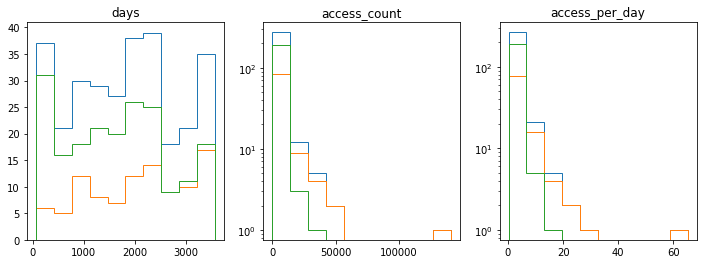

In [2]:
from matplotlib import pyplot as plt
plots = ['days','access_count','access_per_day']
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for i,p in enumerate(plots):
    _, bins, _ = axes[i].hist(df[p], histtype='step')
    axes[i].hist(df_susy[p], bins=bins, histtype='step')
    axes[i].hist(df_nonsusy[p], bins=bins, histtype='step')
    axes[i].set_title(p)
    if 'access' in p:
        axes[i].set_yscale('log')

In [3]:
_ = plt.hist(df['access_per_day'],bins=np.linspace(0,5,21), histtype='step')

# Correcting for automated downloads

From discussions with Andy Buckley and Graeme Watt, many of the reinterpretation collaborations download copies from HepData and synchronize periodically. In addition we also generated accesses when uploading and checking our own records. To correct for all this we subtract a constant "pedestal" of acesses per day, based on either the mode of the distribution, the lower 5% quantile (aggressive), or a 50% higher than the mode (conservative)

In [4]:
pedestal_mode = df['access_per_day'].round(1).mode().item()
pedestal_5percent = df['access_per_day'].quantile(0.05)
pedestal_conservative = pedestal_mode*1.5
print(f"Extracted pedestal based on mode: {pedestal_mode:.2f}, 5% quantile: {pedestal_5percent:.2f}, and 50% above mode {pedestal_conservative:.2f}")
    
def get_df_stats(df, label):
    df['corrected_access_per_day'] = df['access_per_day'] - pedestal_mode
    df['corrected_access_count'] = df['corrected_access_per_day']*df['days']
    df['corrected_access_per_day_5percent_pedestal'] = df['access_per_day'] - pedestal_5percent
    df['corrected_access_per_day_conservative_pedestal'] = df['access_per_day'] - pedestal_conservative

    used_mode = (df['corrected_access_per_day'] > 0).mean()
    used_5percent = (df['corrected_access_per_day_5percent_pedestal'] > 0).mean()
    used_conservative = (df['corrected_access_per_day_conservative_pedestal'] > 0).mean()

    print(f"## Stats for {label}:")
    print(f"Fraction of 'used' HepData records, based on lower 5% pedestal {used_5percent:.2f}" )
    print(f"Fraction of 'used' HepData records, based on mode pedestal {used_mode:.2f}")
    print(f"Fraction of 'used' HepData records, based on conservative pedestal {used_conservative:.2f}")
    
get_df_stats(df, 'Inclusive')
get_df_stats(df_susy, 'SUSY')
get_df_stats(df_nonsusy, 'Non-SUSY')

Extracted pedestal based on mode: 0.80, 5% quantile: 0.50, and 50% above mode 1.20
## Stats for Inclusive:
Fraction of 'used' HepData records, based on lower 5% pedestal 0.95
Fraction of 'used' HepData records, based on mode pedestal 0.82
Fraction of 'used' HepData records, based on conservative pedestal 0.63
## Stats for SUSY:
Fraction of 'used' HepData records, based on lower 5% pedestal 0.99
Fraction of 'used' HepData records, based on mode pedestal 0.90
Fraction of 'used' HepData records, based on conservative pedestal 0.82
## Stats for Non-SUSY:
Fraction of 'used' HepData records, based on lower 5% pedestal 0.93
Fraction of 'used' HepData records, based on mode pedestal 0.77
Fraction of 'used' HepData records, based on conservative pedestal 0.54


In [5]:
df_recent= df[df['days'] < 5*365] #less than 5
df_enoughmargin = df[df['days'] > 2*365 ] #more than 2 years
df_recent_enoughmargin = df[(df['days'] < 5*365) & (df['days'] > 2*365) ] #more than 2 years, less than 5
used_inc = (df['corrected_access_per_day'] > 0).mean()
used_recent = (df_recent['corrected_access_per_day'] > 0).mean()
used_enoughmargin = (df_enoughmargin['corrected_access_per_day'] > 0).mean()
used_recent_enoughmargin = (df_recent_enoughmargin['corrected_access_per_day'] > 0).mean()

histopts = {'histtype':'step','bins':(0,1,2),'density':True, 'align':'left'}
plt.hist(np.where(df['corrected_access_per_day']>0, 'Used', 'Not used'), label=f'All searches: {used_inc:.2f}', **histopts)
plt.hist(np.where(df_recent['corrected_access_per_day']>0, 'Used', 'Not used'), label=f'All searches (years < 5): {used_recent:.2f}', **histopts)
plt.hist(np.where(df_enoughmargin['corrected_access_per_day']>0, 'Used', 'Not used'), label=f'All searches (years > 2): {used_enoughmargin:.2f}', **histopts)
plt.hist(np.where(df_recent_enoughmargin['corrected_access_per_day']>0, 'Used', 'Not used'), label=f'All searches (2 < years < 5): {used_recent_enoughmargin:.2f}', **histopts)
plt.legend()
plt.ylabel("Fraction of records")

Text(0, 0.5, 'Fraction of records')

Text(0, 0.5, 'Fraction of records')

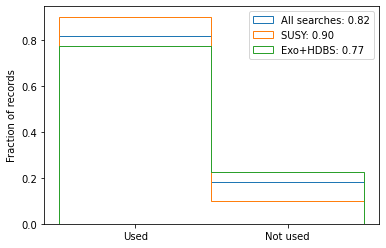

In [6]:
used_susy = (df_susy['corrected_access_per_day'] > 0).mean()
used_nonsusy = (df_nonsusy['corrected_access_per_day'] > 0).mean()

plt.hist(np.where(df['corrected_access_per_day']>0, 'Used', 'Not used'), label=f'All searches: {used_inc:.2f}', **histopts)
plt.hist(np.where(df_susy['corrected_access_per_day']>0, 'Used', 'Not used'),  label=f'SUSY: {used_susy:.2f}', **histopts)
plt.hist(np.where(df_nonsusy['corrected_access_per_day']>0, 'Used', 'Not used'), label=f'Exo+HDBS: {used_nonsusy:.2f}',  **histopts)
plt.legend()
plt.ylabel("Fraction of records")

# Top entries after mode correction

SUSY is proud owner of all of the top 5% except for one scalar leptoquark paper and the CalRatio paper :)

The top entries are the same with/without the correction.


In [7]:
df[df.corrected_access_per_day > df.corrected_access_per_day.quantile(.95)].sort_values(by=['corrected_access_per_day'])

inspire_id  access_count          arxiv_id creation_date last_updated  \
231     1462258         31396  arXiv:1605.06035    2016-05-19   2016-11-24   
190     1630899         26362  arXiv:1710.05544    2017-10-16   2018-06-13   
80      1839446         12470  arXiv:2101.01629    2021-01-05   2021-07-05   
116     1765529         17623  arXiv:1911.06660    2019-11-15   2020-08-19   
64      1906174          9971  arXiv:2108.07586    2021-08-17   2023-08-31   
107     1793461         15830  arXiv:2004.14060    2020-04-29   2021-02-17   
185     1634607         31720  arXiv:1711.01901    2017-11-06   2018-07-26   
144     1704138         26385  arXiv:1811.07370    2018-11-18   2018-12-07   
199     1620694         33554  arXiv:1708.09266    2017-08-30   2018-05-03   
118     1755298         25523  arXiv:1909.09226    2019-09-23   2021-02-17   
182     1639856         40898  arXiv:1711.11520    2017-11-30   2017-12-05   
124     1748602         32107  arXiv:1908.03122    2019-08-08   2021-02-17   
197     1623207         56096  arXiv:1709.04183    2017-09-13   2018-02-20   
122     1750597         48692  arXiv:1908.08215    2019-08-22   2022-05-19   
181     1641270        141086  arXiv:1712.02332    2017-12-06   2021-02-17   

                     journal_info  \
231  New J.Phys. 18 (2016) 093016   
190   Phys.Rev.D 97 (2018) 032003   
80     Eur.Phys.J.C 81 (2021) 600   
116  Phys.Rev.D 101 (2020) 032009   
64   Phys.Rev.D 104 (2021) 112010   
107    Eur.Phys.J.C 80 (2020) 737   
185            JHEP 06 (2018) 107   
144   Phys.Rev.D 99 (2019) 052005   
199            JHEP 11 (2017) 195   
118    Eur.Phys.J.C 80 (2020) 691   
182            JHEP 06 (2018) 108   
124            JHEP 12 (2019) 060   
197            JHEP 12 (2017) 085   
122    Eur.Phys.J.C 80 (2020) 123   
181   Phys.Rev.D 97 (2018) 112001   

                                                 title    days  \
231  Search for scalar leptoquarks in $pp$ collisio...  2732.0   
190  A search for $B-L$ $R$-parity-violating top sq...  2217.0   
80   Search for squarks and gluinos in final states...  1040.0   
116  Search for direct stau production in events wi...  1457.0   
64   Search for charginos and neutralinos in final ...   816.0   
107  Search for a scalar partner of the top quark i...  1291.0   
185  Search for Supersymmetry in final states with ...  2196.0   
144  Search for long-lived particles produced in $p...  1819.0   
199  Search for supersymmetry in events with $b$-ta...  2264.0   
118  Search for direct production of electroweakino...  1510.0   
182  Search for top-squark pair production in final...  2172.0   
124  Search for bottom-squark pair production with ...  1556.0   
197  Search for a scalar partner of the top quark i...  2250.0   
122  Search for electroweak production of charginos...  1542.0   
181  Search for squarks and gluinos in final states...  2166.0   

     access_per_day  IsSUSY  corrected_access_per_day  corrected_access_count  \
231       11.491947       0                 10.691947                 29210.4   
190       11.890843       1                 11.090843                 24588.4   
80        11.990385       1                 11.190385                 11638.0   
116       12.095402       1                 11.295402                 16457.4   
64        12.219363       1                 11.419363                  9318.2   
107       12.261813       1                 11.461813                 14797.2   
185       14.444444       1                 13.644444                 29963.2   
144       14.505223       0                 13.705223                 24929.8   
199       14.820671       1                 14.020671                 31742.8   
118       16.902649       1                 16.102649                 24315.0   
182       18.829650       1                 18.029650                 39160.4   
124       20.634319       1                 19.834319                 30862.2   
197       24.931556       1                 24.131556

# Take-home message

**After correcting for the mode of the downloads, more than 80% of our records are actively used. With a more conservative definition of the pedestal 65% of our records are used.**

This picture changes significantly across groups, with the nominal 82% being actually 90% (77%) for SUSY (non-SUSY) papers